### Import libraries

In [0]:
import random

import numpy as np
from skimage.transform import resize

from keras.datasets import mnist
from keras.utils import np_utils

import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Load MNIST

In [2]:

mnist_img_height , mnist_img_width = 28 , 28
(x_train,y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [3]:
print(f"Number of train images:{x_train.shape[0]}")
print(f"Number of test images:{x_test.shape[0]}")

Number of train images:60000
Number of test images:10000


### Build two-digit mnist sequences 

In [0]:
def build_sequence_mnist(data,labels,dataset_size,IS_TRAIN=True):
    
    # sequence data size
    seq_img_height = 64
    seq_img_width = 64
    
    seq_data = np.ndarray(shape=(dataset_size,seq_img_height,seq_img_width),
                           dtype=np.float32)
    seq_labels = [] 
    
    for i in range(0,dataset_size):
        
        #Pick a random number of digits to be in the dataset
        # num_digits = random.randint(1,2)
        
        s_indices = [random.randint(0,len(data)-1) for p in range(0,2)]

        if IS_TRAIN:
          # concatenating images and labels together
          new_image = np.hstack([x_train[index] for index in s_indices])
          new_label =  [y_train[index] for index in s_indices]
        else:

          new_image = np.hstack([x_test[index] for index in s_indices])
          new_label =  [y_test[index] for index in s_indices]
        
        
        #Resize image
        new_image = resize(new_image,(seq_img_height,seq_img_width))
        
        seq_data[i,:,:] = new_image
        seq_labels.append(tuple(new_label))
        
    
    #Return the synthetic dataset
    return seq_data,seq_labels


In [0]:
x_seq_train,y_seq_train = build_sequence_mnist(x_train,y_train,60000)
x_seq_test,y_seq_test = build_sequence_mnist(x_test,y_test,10000,IS_TRAIN=False)

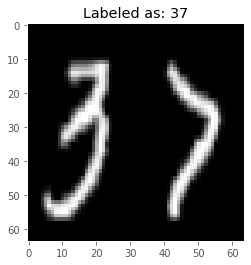

In [8]:
RANDOM_IMG_TO_SHOW = 2
plt.figure()
plt.imshow(x_seq_test[RANDOM_IMG_TO_SHOW], cmap='gray')
plt.title("Labeled as: {}".format(''.join(str(i) for i in y_seq_test[RANDOM_IMG_TO_SHOW])))
plt.grid(b=None)
plt.show()

### One-Hot encoding

In [0]:
#Converting labels to One-hot representations of shape (set_size,digits,classes)
possible_classes = 10

def convert_labels(labels):
        
    #Declare output ndarrays
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))

    
    for index,label in enumerate(labels):
        
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        
    return [dig0_arr,dig1_arr]

In [0]:
train_labels = convert_labels(y_seq_train)
test_labels = convert_labels(y_seq_test)

In [15]:
np.shape(test_labels[0])

(10000, 10)

### Define Model  --> a simple model

In [44]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPool2D, TimeDistributed, LSTM, GlobalAveragePooling2D, Convolution2D, MaxPooling2D, BatchNormalization
from keras.applications.resnet50 import ResNet50
from keras.applications import VGG16
from keras.optimizers import RMSprop

nb_classes = 10

img_rows = 64
img_cols = 64
img_channels = 1

#number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

#defining the input
inputs = Input(shape=(img_rows,img_cols,img_channels))

#Model taken from keras example. Worked well for a digit, dunno for multiple
cov = Convolution2D(nb_filters,kernel_size,padding='same')(inputs)
cov = Activation('relu')(cov)
cov = BatchNormalization()(cov)
cov = Convolution2D(nb_filters,kernel_size)(cov)
cov = Activation('relu')(cov)
cov = BatchNormalization()(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.25)(cov)
cov_out = Flatten()(cov)
cov2 = Dense(128, activation='relu')(cov_out)
cov2 = Dropout(0.5)(cov2)


#Prediction layers
c0 = Dense(nb_classes, activation='softmax', name='digit1')(cov2)
c1 = Dense(nb_classes, activation='softmax', name='digit2')(cov2)

#Defining the model
model = Model(inputs=inputs,outputs=[c0,c1],name='custom-simple-model')

#Compiling the model
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(lr=0.001),metrics=['accuracy'])
model.summary()


Model: "custom-simple-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 64, 64, 32)   320         input_9[0][0]                    
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 64, 64, 32)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 64, 64, 32)   128         activation_13[0][0]              
________________________________________________________________________________

### Prepare Data

In [42]:
def prep_data_keras(img_data):
    
    img_data = img_data.reshape(len(img_data),64,64,1)
    img_data = img_data.astype('float32')
    img_data /= 255.0
    
    return img_data

train_images = prep_data_keras(x_seq_train)
test_images = prep_data_keras(x_seq_test)
print(f"Train Image Shape: {test_images.shape}")

Train Image Shape: (10000, 64, 64, 1)


### Define callbacks and call model.fit()

In [45]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import numpy as np

save_dir = 'two-digit-custom-model-test2-with-batchnormalization.h5'
model_checkpoint = ModelCheckpoint(save_dir, 
							monitor='val_loss', verbose=1, 
							save_best_only=True, mode='min')

lr_sched = LearningRateScheduler(lambda epoch: 1e-4 * (0.75 ** np.floor(epoch / 2)))

early = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
                      
hist = model.fit(train_images,train_labels,batch_size=32,epochs=50,verbose=2,validation_split=0.2, callbacks=[model_checkpoint, lr_sched, early])

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
 - 57s - loss: 1.2767 - digit1_loss: 0.6351 - digit2_loss: 0.6416 - digit1_accuracy: 0.7971 - digit2_accuracy: 0.7934 - val_loss: 12.3210 - val_digit1_loss: 6.7812 - val_digit2_loss: 5.5399 - val_digit1_accuracy: 0.2013 - val_digit2_accuracy: 0.4107

Epoch 00001: val_loss improved from inf to 12.32104, saving model to two-digit-custom-model-test2-with-batchnormalization.h5
Epoch 2/50
 - 56s - loss: 0.6821 - digit1_loss: 0.3401 - digit2_loss: 0.3420 - digit1_accuracy: 0.8930 - digit2_accuracy: 0.8928 - val_loss: 60.3461 - val_digit1_loss: 29.8177 - val_digit2_loss: 30.5284 - val_digit1_accuracy: 0.1690 - val_digit2_accuracy: 0.1968

Epoch 00002: val_loss did not improve from 12.32104
Epoch 3/50
 - 56s - loss: 0.5029 - digit1_loss: 0.2500 - digit2_loss: 0.2529 - digit1_accuracy: 0.9227 - digit2_accuracy: 0.9220 - val_loss: 1.6607 - val_digit1_loss: 0.8926 - val_digit2_loss: 0.7682 - val_digit1_accuracy: 0.8438 - val_digit2_accu

### Model Visualization

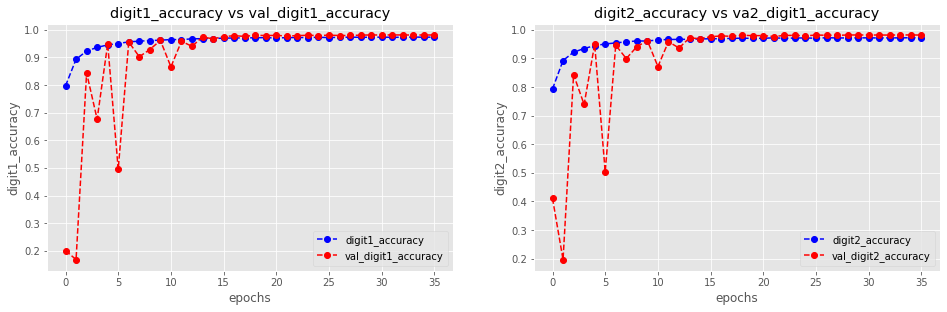

In [47]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(16,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(hist.history['digit1_accuracy'],'bo--', label = "digit1_accuracy")
    plt.plot(hist.history['val_digit1_accuracy'], 'ro--', label = "val_digit1_accuracy")
    plt.title("digit1_accuracy vs val_digit1_accuracy")
    plt.ylabel("digit1_accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(hist.history['digit2_accuracy'],'bo--', label = "digit2_accuracy")
    plt.plot(hist.history['val_digit2_accuracy'], 'ro--', label = "val_digit2_accuracy")
    plt.title("digit2_accuracy vs va2_digit1_accuracy")
    plt.ylabel("digit2_accuracy")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
  
plot_accuracy_loss(hist)

### Save model weights

In [0]:
!cp two-digit-custom-model-test2-with-batchnormalization.h5 drive/My\ Drive/mnist-generator/.

### Load Model

In [0]:
!cp drive/My\ Drive/mnist-generator/two-digit-custom-model-test2-with-batchnormalization.h5 .

In [0]:
model.load_weights('two-digit-custom-model-test2-with-batchnormalization.h5')

### Evaluate model on test

In [49]:
scores = model.evaluate(test_images, test_labels)
print(f"First digit accuracy: {scores[3]} , Second digit accuracy: {scores[4]}")

10000/10000 [==============================] - 4s 374us/step
First digit accuracy: 0.9805999994277954 , Second digit accuracy: 0.9818999767303467


### Model Inference

In [50]:
#Printing some examples of real and predicted labels
predictions = model.predict(test_images)

for i in random.sample(range(0,10000),50):
    
    actual_labels = []
    predicted_labels = []
    
    for j in range(0,2):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))

Actual labels: [1, 4]
Predicted labels: [1, 4]

Actual labels: [2, 7]
Predicted labels: [2, 7]

Actual labels: [0, 7]
Predicted labels: [0, 7]

Actual labels: [0, 6]
Predicted labels: [0, 6]

Actual labels: [6, 8]
Predicted labels: [6, 8]

Actual labels: [8, 4]
Predicted labels: [8, 4]

Actual labels: [6, 4]
Predicted labels: [6, 4]

Actual labels: [6, 8]
Predicted labels: [6, 8]

Actual labels: [5, 8]
Predicted labels: [5, 8]

Actual labels: [1, 1]
Predicted labels: [1, 1]

Actual labels: [5, 8]
Predicted labels: [5, 8]

Actual labels: [1, 1]
Predicted labels: [1, 1]

Actual labels: [4, 4]
Predicted labels: [4, 4]

Actual labels: [1, 4]
Predicted labels: [1, 4]

Actual labels: [2, 0]
Predicted labels: [2, 0]

Actual labels: [6, 0]
Predicted labels: [6, 0]

Actual labels: [2, 2]
Predicted labels: [2, 2]

Actual labels: [4, 1]
Predicted labels: [4, 1]

Actual labels: [2, 3]
Predicted labels: [2, 3]

Actual labels: [2, 8]
Predicted labels: [2, 8]

Actual labels: [1, 6]
Predicted labels: 